<center><h1>In the name of Allah</h1></center>

Name: Ehsan Hassanbeygi

Student Number: 402211723

In this notebook, you will explore adversarial attacks and training methods in deep learning. First, you will train a simple model, ResNet18, on the CIFAR-10 dataset. Next, you will learn about two different adversarial attacks: FGSM (Fast Gradient Sign Method) and PGD (Projected Gradient Descent). To enhance your understanding, you will implement the PGD attack from scratch, while the FGSM attack will be implemented using a library. After this, you will use the FGSM attack to generate adversarial examples and then perform adversarial training on the model using the CIFAR-10 dataset. Finally, you will compare the performance and robustness of the adversarially trained model with the original model. 

Good luck!

## outline
- Train Resnet on CIFAR10
- FGSM Attack using torchattacks
- PGD Attack from scratch
- Visualization
- Adversarial Training


In [22]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
from tqdm import tqdm

In [23]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


## Train Resnet on CIFAR10 (15 pts)

In [24]:
# Prepare Cifar10 data
batch_size = 128
num_workers = 2
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

##############################################################################
# Prepare training and test datasets and dataloaders                         #
##############################################################################
trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers
)
testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=num_workers
)
################################ End #########################################

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

100%|██████████| 170498071/170498071 [00:03<00:00, 48224897.86it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [25]:
# model architecture
class Resnet(nn.Module):
    def __init__(self, num_cls):
        super().__init__()
        self.conv = nn.Sequential(*list(resnet18(weights=None).children())[:-2])
        self.fc = nn.Linear(512, num_cls)

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, start_dim=1)
        logits = self.fc(x)
        return logits


##############################################################################
# Initialize model and move to device                                        #
##############################################################################
model = Resnet(len(classes)).to(device)

################################ End #########################################

In [26]:
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
epochs = 100

In [31]:
# ##############################################################################
# # Implement train loop and log training loss after each epoch                #
# ##############################################################################

# model.train()
# for epoch in range(epochs):
#     n_correct = 0
#     running_loss = 0
#     for X, y in trainloader:
#         X = X.to(device)
#         y = y.to(device)

#         y_hat = model(X)
#         loss = criterion(y_hat, y)
#         y_pred = y_hat.argmax(dim=1)

#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()

#         running_loss += loss.item()
#         n_correct += torch.sum(torch.eq(y_pred, y))

#     loss = running_loss / len(trainloader)
#     acc = n_correct / len(trainloader.dataset)
#     print(
#         f"Epoch [{epoch+1}/{epochs}], Training Loss= {loss:.4f}, Training Acc= {acc:.4f}"
#     )

# ################################ End #########################################

# # Save model
model_name = "resnet18_cifar10_model_pretrained.pth"
model_PATH = f"/kaggle/input/dl-hw5-adversarial-training-resnet-model/{model_name}"
# model.eval()
# torch.save(model.state_dict(), model_PATH)

In [32]:
model = Resnet(len(classes)).to(device)
model.load_state_dict(torch.load(model_PATH))
model = model.to(device)

In [33]:
##############################################################################
# Evaluate the trained model on test set and print test accuracy             #
##############################################################################
def eval_model(model, testloader, attack=None):
    model.eval()
    n_correct = 0
    running_loss = 0
    for X, y in testloader:
        X = X.to(device)
        y = y.to(device)

        if attack is not None:
            X = attack(X, y)

        with torch.no_grad():
            y_hat = model(X)
        loss = criterion(y_hat, y)
        y_pred = y_hat.argmax(dim=1)

        running_loss += loss.item()
        n_correct += torch.sum(torch.eq(y_pred, y))

    loss = running_loss / len(testloader)
    acc = n_correct / len(testloader.dataset)

    return loss, acc


loss, acc = eval_model(model, testloader)
print(f"Test Loss= {loss:.4f}, Test Acc= {acc:.4f}")


################################ End #########################################

Test Loss= 2.0286, Test Acc= 0.7558


## FGSM Attack using torchattacks (10 pts)

In this section you should run FGSM attack using torchattacks library (https://adversarial-attacks-pytorch.readthedocs.io/en/latest/index.html).

Run the attack for $\epsilon \in \{\frac{1}{255}, \frac{4}{255}, \frac{8}{255},\}$ report the performance of the model on untargeted FGSM attack on the test data.

In [35]:
!pip install torchattacks

In [36]:
##############################################################################
# run untargeted FGSM attack for epsilon = 1/255, 4/255, 8/255               #
##############################################################################
import torchattacks

for epsilon in (1 / 255, 4 / 255, 8 / 255):
    attack = torchattacks.FGSM(model, eps=epsilon)
    loss, acc = eval_model(model, testloader, attack)
    print(
        f"FGSM with epsilon= {epsilon:.4f} model acc= {acc:.4f}, model loss= {loss:.4f}"
    )

################################ End #########################################

FGSM with epsilon= 0.0039 model acc= 0.5402, model loss= 4.9771
FGSM with epsilon= 0.0157 model acc= 0.2448, model loss= 14.6747
FGSM with epsilon= 0.0314 model acc= 0.1215, model loss= 22.3993


## PGD Attack from scratch (30 pts)

In this section you should implement PGD attack from scratch.

In [37]:
# vectorized version
class LinfPGDAttack(object):

    def __init__(self, model, epsilon=8 / 255, k=2, alpha=2 / 255):
        self.model = model
        self.epsilon = epsilon
        self.steps = k
        self.alpha = alpha

    def __call__(self, images, label):

        images = images.to(device)
        label = label.to(device)

        out = self.model(images)
        pred = out.argmax(dim=1)
        perturbed_images = images.clone()
        perturbed_images.to(device)

        # just perturb the samples that are correctly classified
        pert_imgs = perturbed_images[pred == label]
        pert_labels = label[pred == label]
        pert_indices = torch.nonzero(pred == label, as_tuple=True)[0]

        ##############################################################################
        # Implement a k step PGD attack of size alpha                                #
        # while always staying within epsilon distance from the initial point        #
        # Use cross entropy loss                                                     #
        ##############################################################################

        for _ in range(self.steps):
            pert_imgs.requires_grad = True
            y_hat = self.model(pert_imgs)
            loss = F.cross_entropy(y_hat, pert_labels)
            loss.backward()
            self.model.zero_grad()

            # perturbed_images.grad is the gradient of loss w.r.t perturbed_image
            gradient_sign = pert_imgs.grad.sign()
            pert_imgs = pert_imgs + self.alpha * gradient_sign

            # projection on epsilon ball
            pert_imgs = torch.max(
                torch.min(pert_imgs, images[pred == label] + self.epsilon),
                images[pred == label] - self.epsilon,
            )
            pert_imgs = torch.clamp(pert_imgs, 0, 1)
            pert_imgs = pert_imgs.detach()

        perturbed_images[pert_indices] = pert_imgs

        return perturbed_images

In [38]:
##############################################################################
# Evaluate PGD attack on the trained model with k=2,4,8                      #
##############################################################################

for k in (2, 4, 8):
    attack = LinfPGDAttack(model, k=k)
    loss, acc = eval_model(model, testloader, attack)
    print(f"PGD with k= {k} model acc= {acc:.4f}, model loss= {loss:.4f}")

################################ End #########################################

PGD with k= 2 model acc= 0.1694, model loss= 11.4589
PGD with k= 4 model acc= 0.0304, model loss= 24.5144
PGD with k= 8 model acc= 0.0087, model loss= 31.1523


## Visualization (10 pts)

Implement a function to plot the original image, the perturbed imaged and their predicted labels by the model

In [61]:
##############################################################################
# Implement the function described                                           #
##############################################################################
import matplotlib.pyplot as plt


def plot_images(orig_img, orig_label, pert_img, pred_label):
    pert = orig_img - pert_img

    _, ax = plt.subplots(1, 3, figsize=(15, 20))
    ax[0].imshow(orig_img.squeeze().detach().cpu().permute(1, 2, 0).numpy())
    ax[0].set_title(f"original image\nlabel: {classes[orig_label]}")
    ax[0].axis("off")

    ax[1].imshow(pert_img.squeeze().detach().cpu().permute(1, 2, 0).numpy())
    ax[1].set_title(f"adversarial image\nlabel: {classes[pred_label]}")
    ax[1].axis("off")

    ax[2].imshow(100 * pert.squeeze().detach().cpu().permute(1, 2, 0).numpy())
    ax[2].set_title("perturbation")
    ax[2].axis("off")

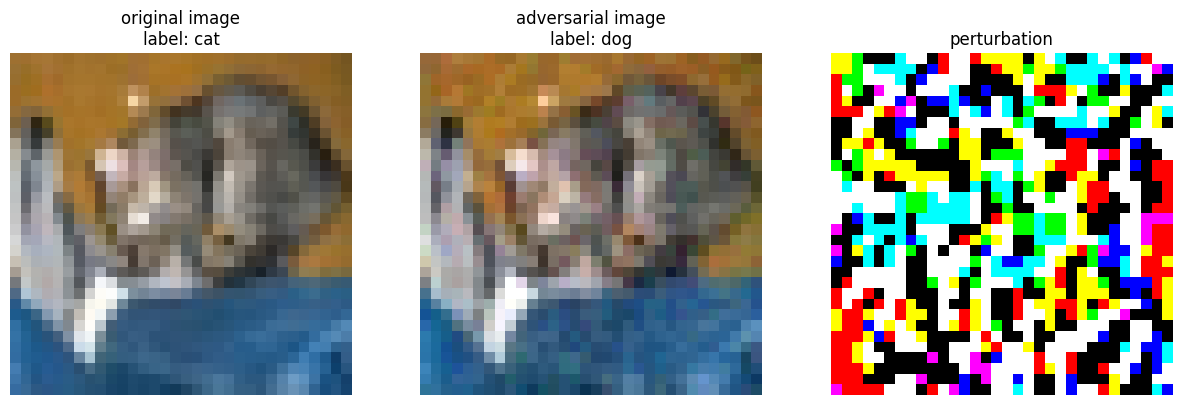

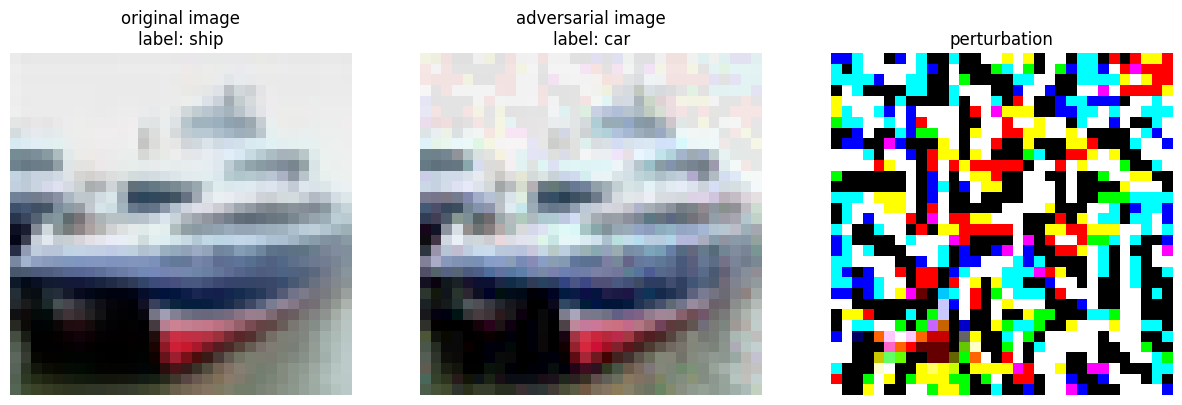

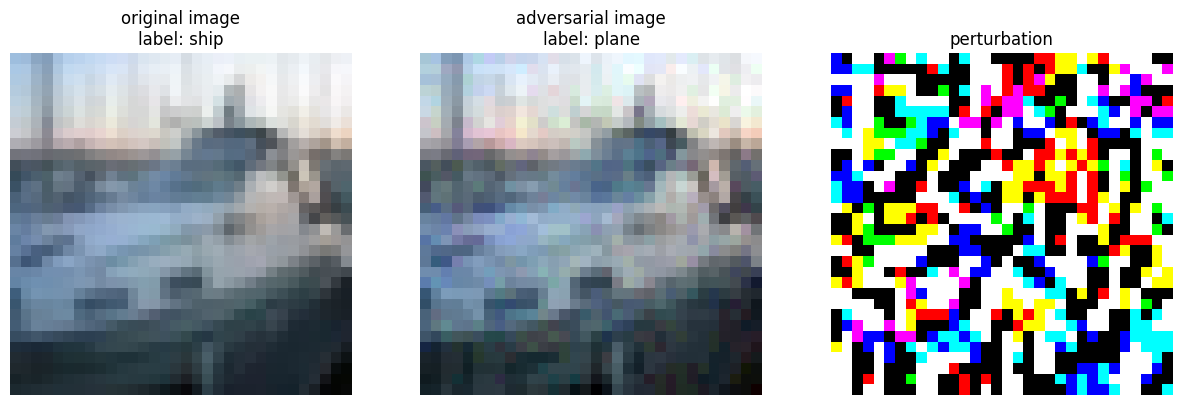

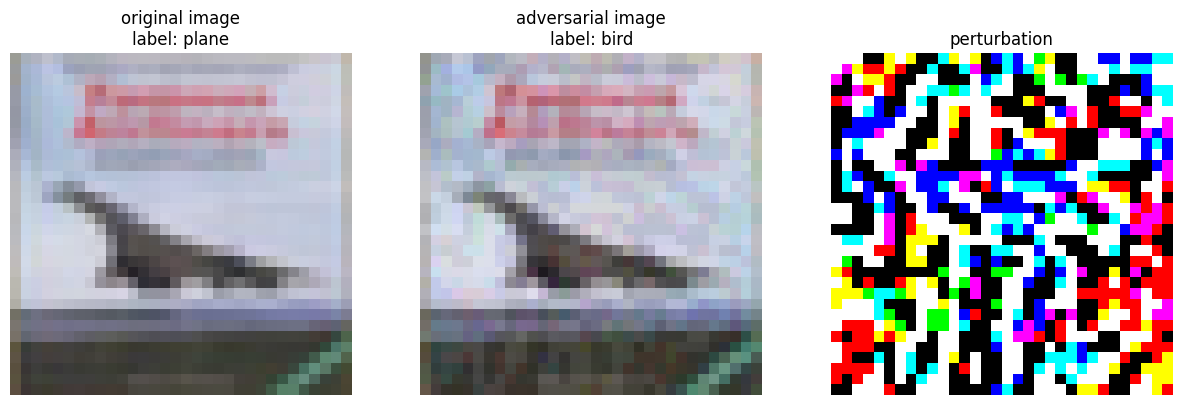

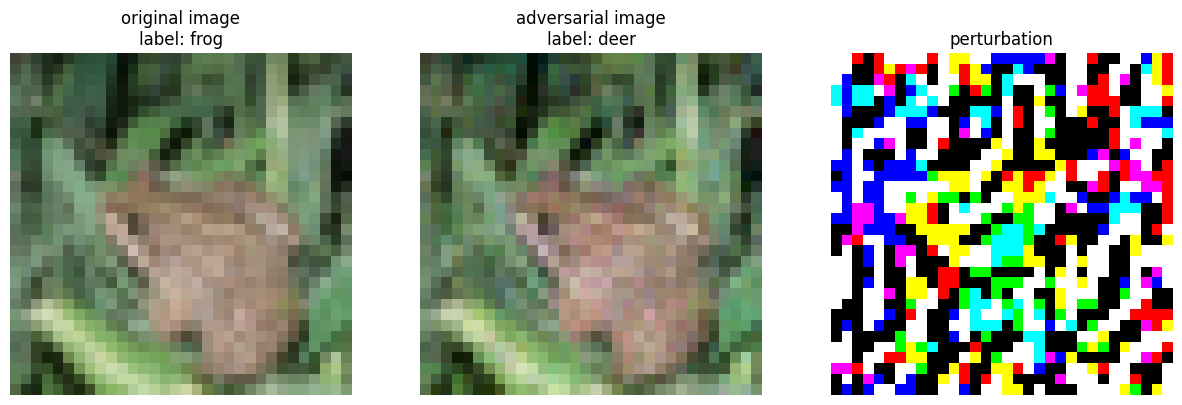

In [62]:
##############################################################################
# Choose 3 random images from testset and run FGSM attack and visualize      #
##############################################################################

epsilon = 8 / 255
sample_count = 5
fgsm_attack = torchattacks.FGSM(model, eps=epsilon)
sample_list = []

model.eval()
for X, y in testloader:
    if len(sample_list) >= sample_count:
        sample_list = sample_list[:sample_count]
        break
    X = X.to(device)
    y = y.to(device)
    X_adv = fgsm_attack(X, y)
    with torch.no_grad():
        y_hat = model(X_adv)

    y_pred = y_hat.argmax(dim=1)
    sample_list += list(
        zip(X[y_pred != y], y[y_pred != y], X_adv[y_pred != y], y_pred[y_pred != y])
    )


for s in sample_list:
    plot_images(*s)

################################ End #########################################

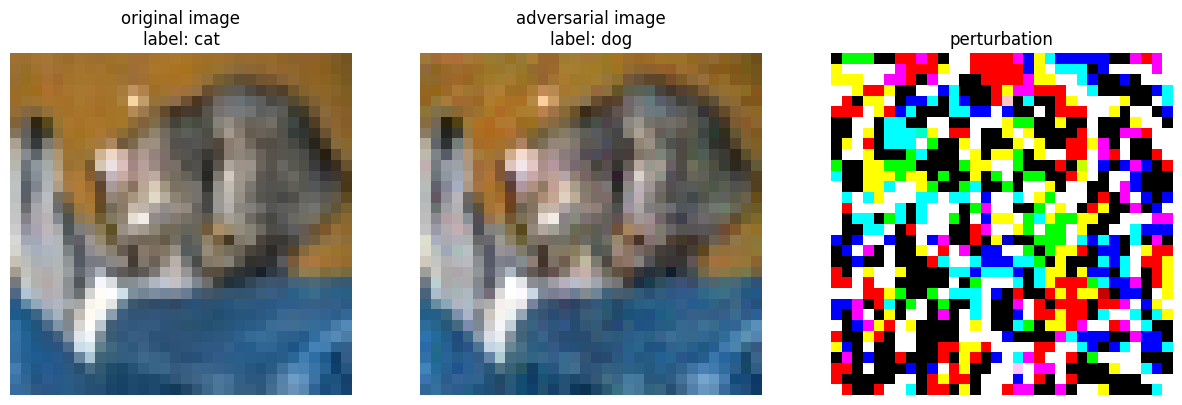

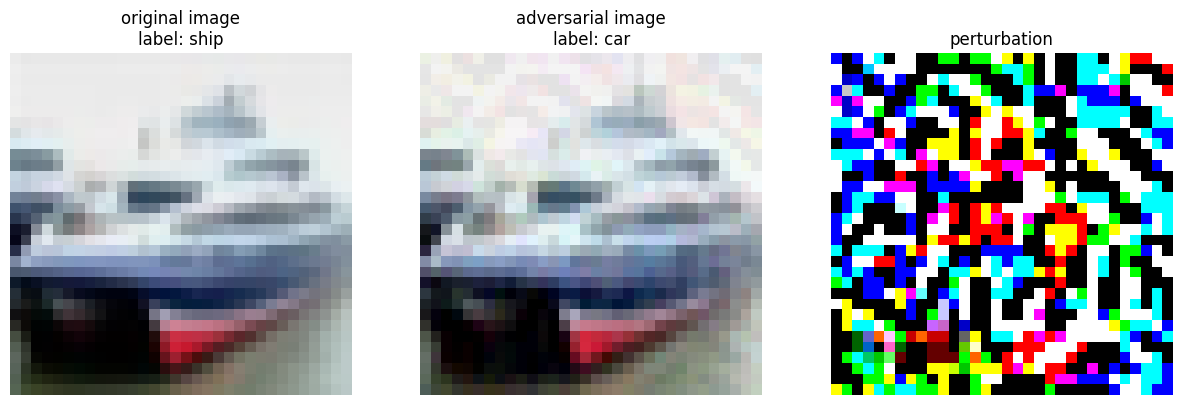

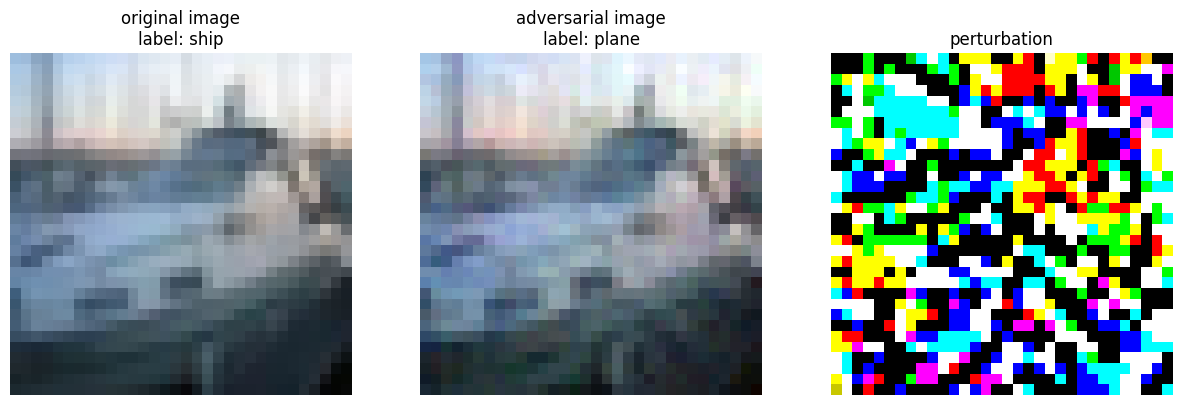

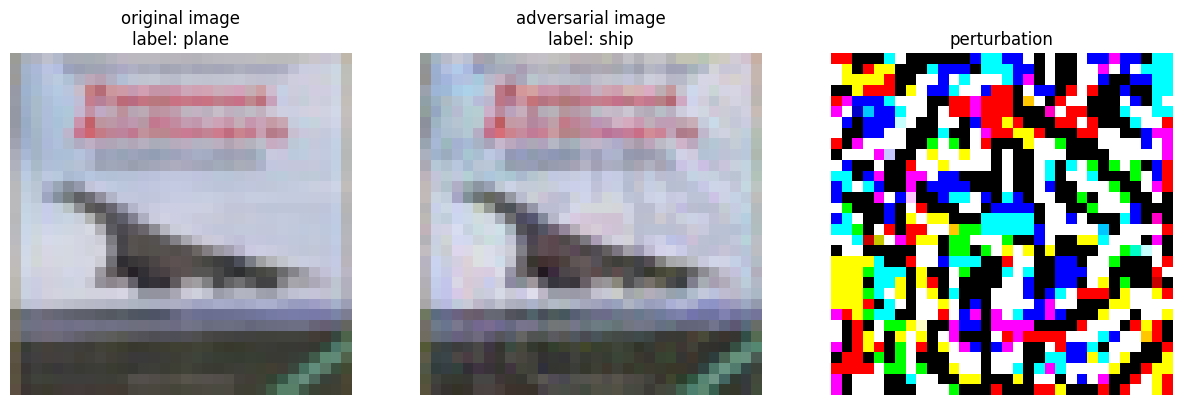

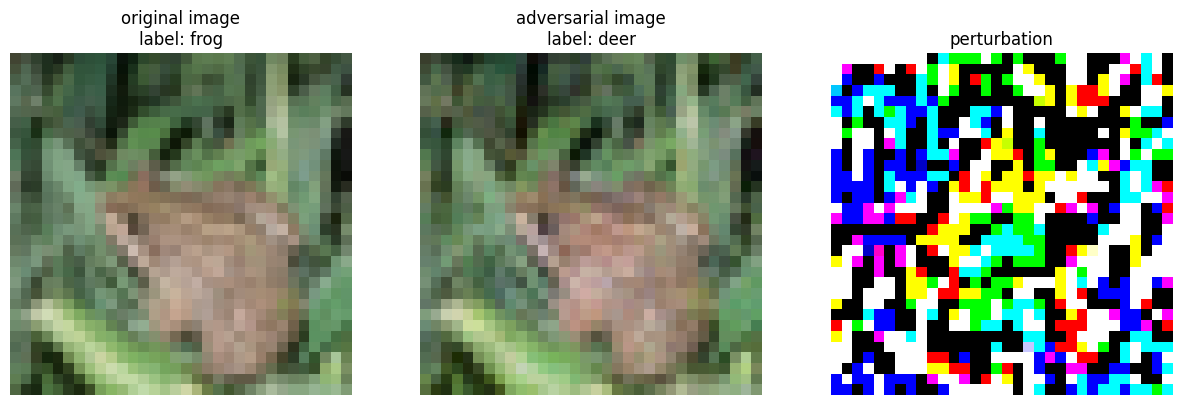

In [63]:
##############################################################################
# Choose 3 random images from testset and run PGD attack and visualize      #
##############################################################################

k = 8
sample_count = 5
pgd_attack = LinfPGDAttack(model, k=k)
sample_list = []

model.eval()
for X, y in testloader:
    if len(sample_list) >= sample_count:
        sample_list = sample_list[:sample_count]
        break
    X = X.to(device)
    y = y.to(device)
    X_adv = pgd_attack(X, y)
    with torch.no_grad():
        y_hat = model(X_adv)

    y_pred = y_hat.argmax(dim=1)
    sample_list += list(
        zip(X[y_pred != y], y[y_pred != y], X_adv[y_pred != y], y_pred[y_pred != y])
    )


for s in sample_list:
    plot_images(*s)

################################ End #########################################

## Adversarial Training (35 pts)

In this section you are going to adversarially train your model and see the results. 

In [ ]:
##############################################################################
# Load a new resnet model for adversarial training                           #
# Train the model on perturbed images from                                   #
# untargeted FGSM attack with epsilon = 8/255 on train dataset               #
# Also use the following setup for training the model                        #
##############################################################################

adv_model = None # Your code goes here
adv_model.to(device)

learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(adv_model.parameters(), lr=learning_rate, momentum=0.9)
epochs = 100


# Your code goes here

################################ End #########################################

In [ ]:
##############################################################################
# Evaluate the new model on the test dataset                                 #
##############################################################################

# Your code goes here

################################ End #########################################

In [ ]:
##############################################################################
# Run FGSM attack on the adversarially trained model with epsilon = 8/255    #
##############################################################################

# Your code goes here

################################ End #########################################

In [ ]:
##############################################################################
#  Run PGD attack on the adversarially trained model with k=4                #
##############################################################################

# Your code goes here

################################ End #########################################

Answer the following questions:
- What happened to the accuracy of the adversarially trained model?
- What do you conclude from the result of the FGSM attack on the adversarially trained model?
- What do you conclude from the result of the PGD attack on the adversarially trained model?
- What is you final conclusion?